In [1]:
# The import statement lets you use functions in other modules
import os
# os has operating system interactions like manipulating paths

# You can change the name upon import for convenience in typing or to avoid overwriting other names
import numpy as np

% matplotlib inline

# A dot gives a submodule or object
import matplotlib.pyplot as plt

# You can also import a submodule, or a portion of a large project
from scipy import stats, linalg

# Array Basics

In [24]:
a = np.array([1, 2])
b = np.array([[1, 2], [1, 2]])
c = np.array([0, 0.5])

In [25]:
# The operations on these are not linear algebra, they are element-wise. No .^, .*, etc!
print(a ** 2.0)
print(b ** 2.0)
print(a * b)

print('\n\n')

# but I can do linear algebra if I want
print(a @ b)
print(b @ b)

print('\n\n')

# Convenient dot product
print(a @ a)

[ 1.  4.]
[[ 1.  4.]
 [ 1.  4.]]
[[1 4]
 [1 4]]



[3 6]
[[3 6]
 [3 6]]



5


## A few Gotchas
Python is smart about copying, but you need to be aware of that! This is a feature that lets you share/update data

In [26]:
d = a
print(d)
a[1] = 5
print(d)

# Go back to how we were
a[1] = 2

[1 2]
[1 5]


You can avoid this by copying or by indexed assignment

In [27]:
d = a.copy()
a[1] = 5
print(d)

# Go back to how we were
a[1] = 2

# OR use this less explcit way
d[:] = a
a[1] = 5
print(d)

# Go back to how we were
a[1] = 2

[1 2]
[1 2]


In [28]:
# Watch out for this!
d = a
d[1] = 5
print(a)

# Go back to how we were
a[1] = 2

[1 5]


# Plotting

Now let's make a really simple plot. The interface is similar to matlab if you want it to be, I'd suggest a more object-oriented approach though. This let's you get comfortable with the different players, and customization becomes easier.
### First, the "matlab" way:

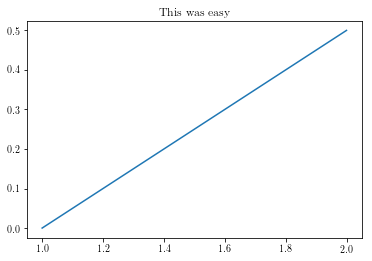

In [29]:
plt.figure()
plt.plot(a, c)
plt.title('This was easy')
plt.show()

### Now the object-oriented way

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


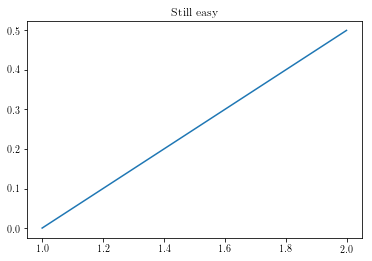

In [31]:
fig, ax = plt.subplots() # or fig = plt.figure(); ax = plt.gca();
ax.plot(a, c)
ax.set_title('Still easy')
fig.show()

# Now let's use some scipy
## The problem
We have some noisy data provided in `data.txt` (if you want to make your own, you can use `make_datafile.py`). We want to make a nice plot with the data and a regressed fit. 
## Our approach
We will read the data in using pure python, then make numpy arrays out the data. We will then use a manual algorithm to compute a linear fit to get some practice with numpy, then we will fit the data using a canned routine. Then we will try to make a really pretty plot.

In [9]:
# Read in the noisy data
with open('../data/data.txt', 'r') as fin:
    lines = fin.readlines()
    
lines = [line.rstrip('\n\r').split(' ') for line in lines]
lines = [list(map(float, line)) for line in lines]
data = np.array(lines)

In [10]:
# Read in the noisy data
with open('../data/data_nonoise.txt', 'r') as fin:
    lines = fin.readlines()
    
lines = [line.rstrip('\n\r').split(' ') for line in lines]
lines = [list(map(float, line)) for line in lines]
real_data = np.array(lines)

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


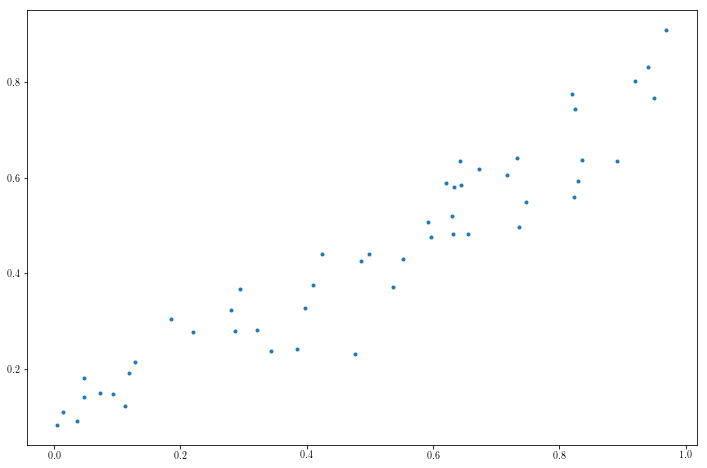

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(data[:, 0], data[:, 1], linestyle='none', marker='.')
fig.show()

## Now let's add error bars, and plot the original data

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


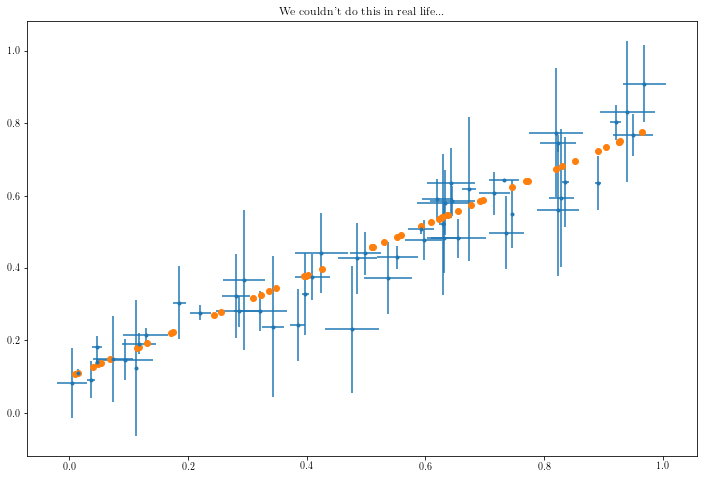

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(data[:, 0], data[:, 1], linestyle='none', marker='.', xerr=data[:, 2], yerr=data[:, 3])
ax.plot(real_data[:, 0], real_data[:, 1], linestyle='none', marker='o')
ax.set_title('We couldn\'t do this in real life...')
fig.show()

## A scipy solution

We'll just use the built-in linear regression. This hands us back a nice object with named parameters. We then can plot our solution

In [13]:
fit_info = stats.linregress(data[:, 0:2])
print(fit_info)

LinregressResult(slope=0.70922264753076569, intercept=0.084074422378990099, rvalue=0.9513843006303454, pvalue=3.393595469808686e-26, stderr=0.033141004550671718)


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


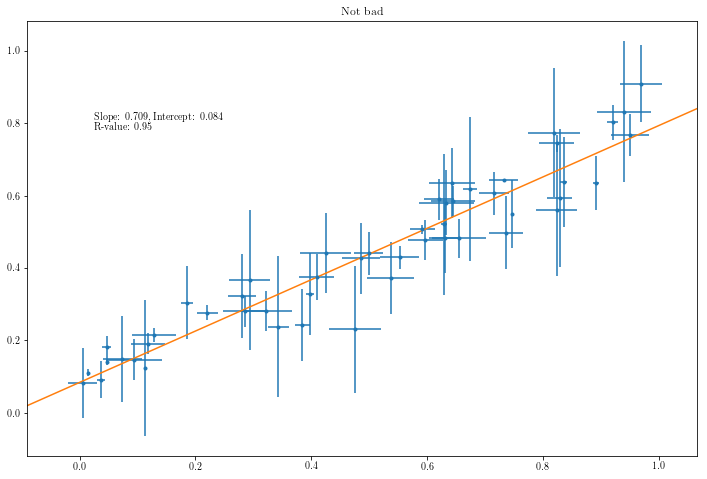

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(data[:, 0], data[:, 1], linestyle='none', marker='.', xerr=data[:, 2], yerr=data[:, 3])
xmin, xmax = np.min(data[:, 0]), np.max(data[:, 0])
fit_x = np.linspace(xmin - (xmax - xmin) / 10., xmax + (xmax - xmin) / 10., 50)
ax.plot(fit_x, fit_x * fit_info.slope + fit_info.intercept)
ax.set_xlim(fit_x[0], fit_x[-1])
ax.text(0.1, 0.75, 'Slope: {:1.3f}, Intercept: {:1.3f}\nR-value: {:1.2f}'.format(fit_info.slope, fit_info.intercept, fit_info.rvalue), transform=ax.transAxes)
ax.set_title('Not bad')
fig.show()

## Now let's do this by hand in a couple different ways

I'm going to take into account the errors in y because this is good practice and really easy; we are minimizing the L2 misfit between each point and the fit, so instead we will just minimimize the misfit over the error at each point, so points with bigger error get less weight.

In [35]:
# Construct a matrix to solve by hand
a = np.ones(data[:, :2].shape)
a[:, 1] = data[:, 0]

# look, this works with numpy

print('By "hand" (svd algorithm) in numpy, no errors accounted for')
print(np.linalg.lstsq(a, data[:, 1])[0])
print('From scipy')
print(fit_info)

# like good mathematicians, we will scale each row of the equations by our error (squared since we minimize the L2 norm)
y_err_sqr = data[:, 3] ** 2.0
scaled_a = a / np.repeat(np.atleast_2d(y_err_sqr), 2, axis=0).T
scaled_obs = data[:, 1] / y_err_sqr


By "hand" (svd algorithm) in numpy, no errors accounted for
[ 0.08407442  0.70922265]
From scipy
LinregressResult(slope=0.70922264753076569, intercept=0.084074422378990099, rvalue=0.9513843006303454, pvalue=3.393595469808686e-26, stderr=0.033141004550671718)


Let's solve this system in two different ways. We'll see how smart the numpy lstsq_sol algorithm is. 

In [16]:
# Now let's solve using a QR factorization
q, r = np.linalg.qr(scaled_a)
# look, QR is nifty:
print(q.T @ q)
print(np.allclose(q @ r, scaled_a))
print(r)

%timeit q, r = np.linalg.qr(scaled_a); lstsq_sol = np.linalg.solve(r, np.dot(q.T, scaled_obs))
%timeit lstsq_sol, _, _, _ = np.linalg.lstsq(scaled_a, scaled_obs)

q, r = np.linalg.qr(scaled_a); lstsq_sol = np.linalg.solve(r, np.dot(q.T, scaled_obs))
lstsq_sol, _, _, _ = np.linalg.lstsq(scaled_a, scaled_obs)

[[  1.00000000e+00   2.15569885e-17]
 [  2.15569885e-17   1.00000000e+00]]
True
[[-56413.259112   -37001.21748792]
 [     0.          12229.78057622]]
118 µs ± 4.95 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
128 µs ± 17.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Oooh, I almost beat it without using the fact that q is upper triangular; I could in fact beat it I were clever about that solve, but who cares. lstsq is easy.

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


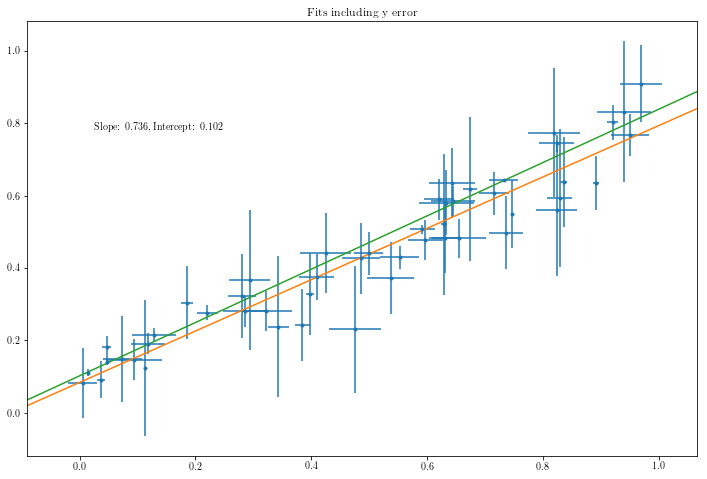

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(data[:, 0], data[:, 1], linestyle='none', marker='.', xerr=data[:, 2], yerr=data[:, 3])
xmin, xmax = np.min(data[:, 0]), np.max(data[:, 0])
fit_x = np.linspace(xmin - (xmax - xmin) / 10., xmax + (xmax - xmin) / 10., 50)
ax.plot(fit_x, fit_x * fit_info.slope + fit_info.intercept)
ax.plot(fit_x, fit_x * lstsq_sol[1] + lstsq_sol[0])
ax.set_xlim(fit_x[0], fit_x[-1])
ax.text(0.1, 0.75, 'Slope: {:1.3f}, Intercept: {:1.3f}'.format(lstsq_sol[1], lstsq_sol[0]), transform=ax.transAxes)
ax.set_title('Fits including y error')
fig.show()

### Now let's take the errors in x into account as well

This may look a little hairy to you, but here is the idea; we need to scale the x-error by the slope because it gets multiplied by the slope when finding the y value. If we don't do this nifty scaling, we will over- or under- estimate the relative importance of x and y errors.

In [18]:
# like good mathematicians, we will scale each row of the equations by our error (squared since we minimize the L2 norm)
weight = np.sqrt(data[:, 3] ** 2.0 + data[:, 2] ** 2.0 * a[:, 1])

scaled_a_xerr = a / np.repeat(np.atleast_2d(weight), 2, axis=0).T
scaled_obs_xerr = data[:, 1] / weight

lstsq_sol_xerr, _, _, _ = np.linalg.lstsq(scaled_a_xerr, scaled_obs_xerr)

/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


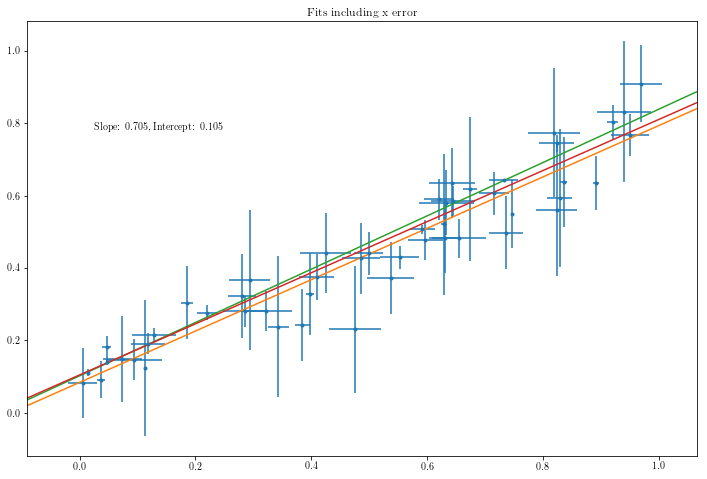

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(data[:, 0], data[:, 1], linestyle='none', marker='.', xerr=data[:, 2], yerr=data[:, 3])
xmin, xmax = np.min(data[:, 0]), np.max(data[:, 0])
fit_x = np.linspace(xmin - (xmax - xmin) / 10., xmax + (xmax - xmin) / 10., 50)
ax.plot(fit_x, fit_x * fit_info.slope + fit_info.intercept)
ax.plot(fit_x, fit_x * lstsq_sol[1] + lstsq_sol[0])
ax.plot(fit_x, fit_x * lstsq_sol_xerr[1] + lstsq_sol_xerr[0])
ax.set_xlim(fit_x[0], fit_x[-1])
ax.text(0.1, 0.75, 'Slope: {:1.3f}, Intercept: {:1.3f}'.format(lstsq_sol_xerr[1], lstsq_sol_xerr[0]), transform=ax.transAxes)
ax.set_title('Fits including x error')

The effectiveness is going to vary based on your random "data," but I have stashed a case that nicely shows improvement when the error gets included.

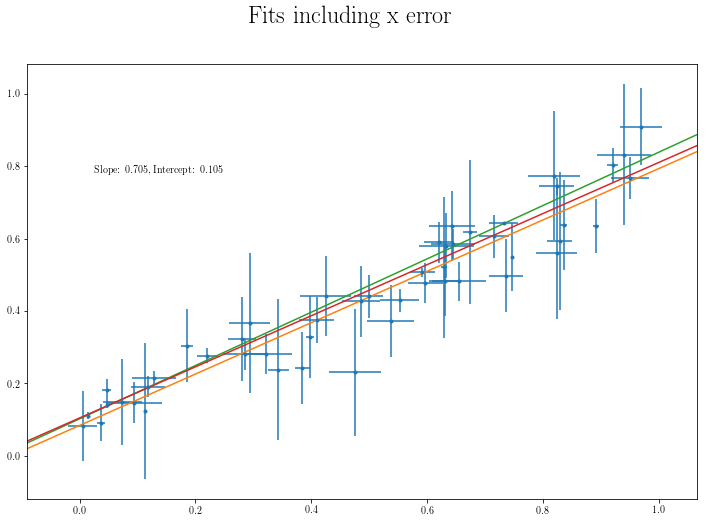

In [43]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(data[:, 0], data[:, 1], linestyle='none', marker='.', xerr=data[:, 2], yerr=data[:, 3])
xmin, xmax = np.min(data[:, 0]), np.max(data[:, 0])
fit_x = np.linspace(xmin - (xmax - xmin) / 10., xmax + (xmax - xmin) / 10., 50)
ax.plot(fit_x, fit_x * fit_info.slope + fit_info.intercept)
ax.plot(fit_x, fit_x * lstsq_sol[1] + lstsq_sol[0])
ax.plot(fit_x, fit_x * lstsq_sol_xerr[1] + lstsq_sol_xerr[0])
ax.set_xlim(fit_x[0], fit_x[-1])
ax.text(0.1, 0.75, 'Slope: {:1.3f}, Intercept: {:1.3f}'.format(lstsq_sol_xerr[1], lstsq_sol_xerr[0]), transform=ax.transAxes)
fig.suptitle('Fits including x error', fontsize=24)

Now let's calculate the error on our fit

In [84]:
N = len(weight)

x_bar = weight * data[:, 0].T / sum(weight) # this is the weighted obs, rescaled
sigma_x = weight * (data[:, 0] - x_bar) @ (data[:, 0] - x_bar).T / sum(weight)

sigma_sq = 1. / (N - 2.) * np.sum(data[:, 1] - lstsq_sol_xerr[0] - lstsq_sol_xerr[1] * data[:, 0]) ** 2.0

sigma_m = np.sqrt(sigma_sq * (1. / N + np.mean(data[:, 0]) ** 2.0 / ((N - 1) * sigma_x)))
sigma_b = np.sqrt(sigma_sq * (1. / ((N - 1.) * sigma_x)))

CI = np.sqrt(sigma_sq * (1. / N + (((fit_x - np.mean(data[:, 0])) ** 2.0) / ((N - 1.) * sigma_x))))

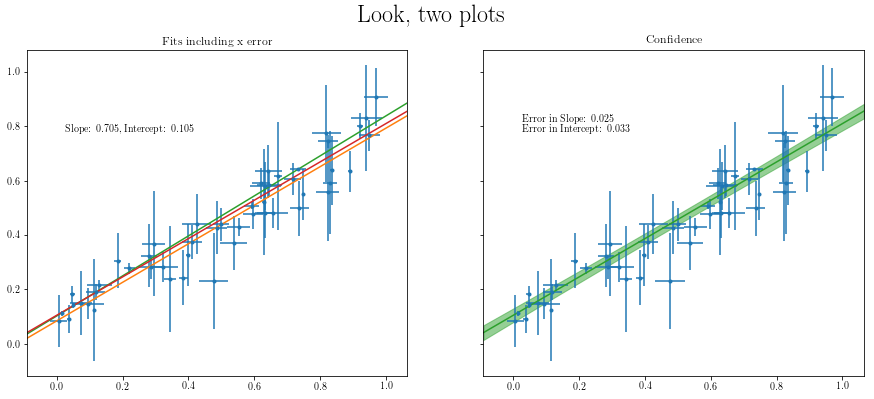

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 6))
ax[0].errorbar(data[:, 0], data[:, 1], linestyle='none', marker='.', xerr=data[:, 2], yerr=data[:, 3])
xmin, xmax = np.min(data[:, 0]), np.max(data[:, 0])
fit_x = np.linspace(xmin - (xmax - xmin) / 10., xmax + (xmax - xmin) / 10., 50)
ax[0].plot(fit_x, fit_x * fit_info.slope + fit_info.intercept)
ax[0].plot(fit_x, fit_x * lstsq_sol[1] + lstsq_sol[0])
ax[0].plot(fit_x, fit_x * lstsq_sol_xerr[1] + lstsq_sol_xerr[0])
ax[0].set_xlim(fit_x[0], fit_x[-1])
ax[0].text(0.1, 0.75, 'Slope: {:1.3f}, Intercept: {:1.3f}'.format(lstsq_sol_xerr[1], lstsq_sol_xerr[0]), transform=ax[0].transAxes)
ax[0].set_title('Fits including x error')
fig.suptitle('Look, two plots', fontsize=24)

ax[1].errorbar(data[:, 0], data[:, 1], linestyle='none', marker='.', xerr=data[:, 2], yerr=data[:, 3])
ax[1].plot(fit_x, fit_x * lstsq_sol_xerr[1] + lstsq_sol_xerr[0], color='C2')
ax[1].fill_between(fit_x, fit_x * lstsq_sol_xerr[1] + lstsq_sol_xerr[0] - CI, fit_x * lstsq_sol_xerr[1] + lstsq_sol_xerr[0] + CI, alpha=0.5, facecolor='C2', edgecolor='C2')
ax[1].text(0.1, 0.75, 'Error in Slope: {:1.3f}\n Error in Intercept: {:1.3f}'.format(sigma_m, sigma_b), transform=ax[1].transAxes)
ax[1].set_title('Confidence')

fig.savefig('two_plots.eps', dpi=300)

